In [1]:
# Imports
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# Shuffle dataset
x_train, y_train = shuffle(x_train, y_train, random_state=0)
x_test, y_test = shuffle(x_test, y_test, random_state=0)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


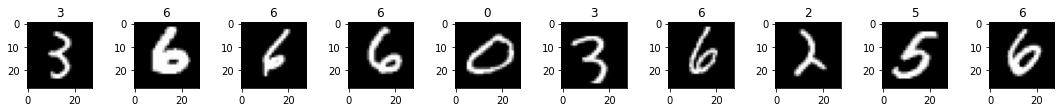

In [4]:
# Plot first 10 train data
fig, axs = plt.subplots(1, 10, figsize=(15, 5))
fig.tight_layout()
for i in range(10):
    axs[i].imshow(x_train[i], cmap='gray')
    axs[i].set_title(y_train[i])

In [5]:
# Reshape to have channel axis
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
# Normalize values between 0-1
x_train = x_train / 255.0
x_test = x_test / 255.0

In [7]:
# To Categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


In [8]:
# Model builder and compiler
def model_factory(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
    )(inputs)

    x = MaxPool2D(pool_size=(2, 2))(x)

    x = Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
    )(x)

    x = MaxPool2D(pool_size=(2, 2))(x)

    x = Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        name='last_conv2d',
    )(x)

    x = MaxPool2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(units=128, activation='relu')(x)
    outputs = Dense(units=10, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy'],
    )

    return model

In [9]:
# Result plotter
def plot_results(acc, val_acc, loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.tight_layout(pad=4)

    ax1.set_title('Accuracy')
    ax1.plot(acc)
    ax1.plot(val_acc)
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['training', 'validation'], loc='lower right')

    ax2.set_title('Loss')
    ax2.plot(loss)
    ax2.plot(val_loss)
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['training', 'validation'], loc='upper right')

    fig.show()

In [10]:
# Build and compile model
input_shape = (28, 28, 1)
model = model_factory(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 last_conv2d (Conv2D)        (None, 7, 7, 64)          36928 

In [11]:
# Train model
BATCH_SIZE = 64
EPOCHS = 15

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/15
938/938 [==============================] - 27s 15ms/step - loss: 0.1727 - accuracy: 0.9462 - val_loss: 0.0506 - val_accuracy: 0.9829
Epoch 2/15
938/938 [==============================] - 10s 10ms/step - loss: 0.0475 - accuracy: 0.9852 - val_loss: 0.0316 - val_accuracy: 0.9904
Epoch 3/15
938/938 [==============================] - 10s 11ms/step - loss: 0.0331 - accuracy: 0.9895 - val_loss: 0.0333 - val_accuracy: 0.9900
Epoch 4/15
938/938 [==============================] - 11s 11ms/step - loss: 0.0250 - accuracy: 0.9922 - val_loss: 0.0327 - val_accuracy: 0.9895
Epoch 5/15
938/938 [==============================] - 10s 11ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 0.0257 - val_accuracy: 0.9919
Epoch 6/15
938/938 [==============================] - 10s 10ms/step - loss: 0.0159 - accuracy: 0.9951 - val_loss: 0.0248 - val_accuracy: 0.9928
Epoch 7/15
938/938 [==============================] - 10s 10ms/step - loss: 0.0147 - accuracy: 0.9949 - val_loss: 0.0334 - val_accuracy:

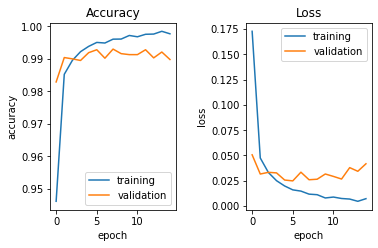

In [12]:
# Plot accuracy and loss
plot_results(
    acc=history.history["accuracy"],
    val_acc=history.history["val_accuracy"],
    loss=history.history["loss"],
    val_loss=history.history["val_loss"],
)

In [13]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [14]:
def make_superimposed(img_array, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    img_array = np.uint8(255 * img_array)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_array
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

In [15]:
def get_images(amount=10):
    images_dict = dict()
    for digit in range(10):
        all_indexes = np.argwhere(np.argmax(y_train, axis=1) == digit).flatten()
        indexes = np.random.choice(all_indexes, amount)        
        digit_list = []
        for i in range(amount):
            temp_image = x_train[indexes[i]]
            digit_list.append(temp_image)
        images_dict[str(digit)] = digit_list
    return images_dict

In [16]:
def plot_ten_examples(digit):
    fig, axs = plt.subplots(3, 10, figsize=(15, 5))
    fig.tight_layout()
    for i in range(10):
        axs[0][i].imshow(np.squeeze(images_dict[digit][i], axis=2), cmap='gray')
        axs[1][i].imshow(heatmap_dict[digit][i])
        axs[2][i].imshow(superimposed_dict[digit][i])

In [17]:
images_dict = get_images()

In [18]:
print(images_dict['0'][0].shape)

(28, 28, 1)


In [19]:
last_conv_layer_name = 'last_conv2d'
model.layers[-1].activation = None

In [20]:
heatmap_dict = dict()
superimposed_dict = dict()

for digit in range(10):
    heatmap_list = []
    superimposed_list = []
    for image in images_dict[str(digit)]:
        heatmap = make_gradcam_heatmap(np.expand_dims(image, 0), model, last_conv_layer_name)
        superimposed = make_superimposed(image, heatmap)
        heatmap_list.append(heatmap)
        superimposed_list.append(superimposed)
    heatmap_dict[str(digit)] = heatmap_list
    superimposed_dict[str(digit)] = superimposed_list

In [21]:
print(heatmap_dict['0'][0].shape)
print(superimposed_dict['0'][0])

(7, 7)
<PIL.Image.Image image mode=RGB size=28x28 at 0x7F61A7E20390>


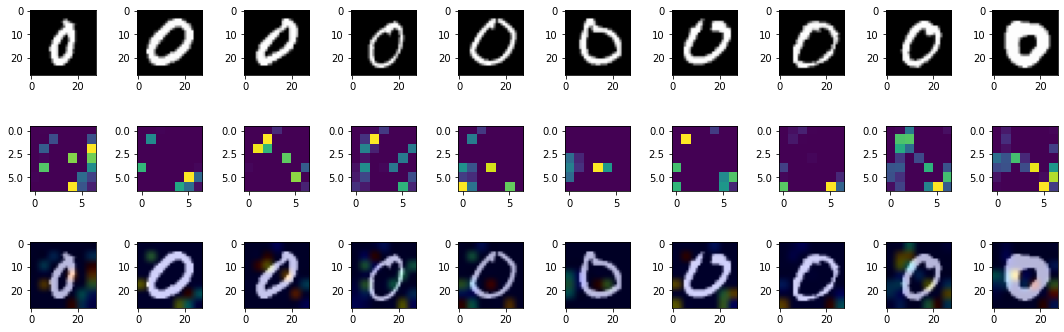

In [22]:
DIGIT = '0'
plot_ten_examples(DIGIT)

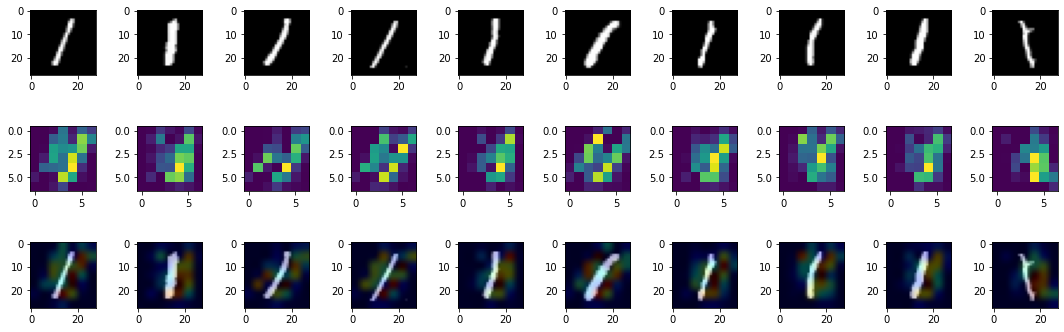

In [23]:
DIGIT = '1'
plot_ten_examples(DIGIT)

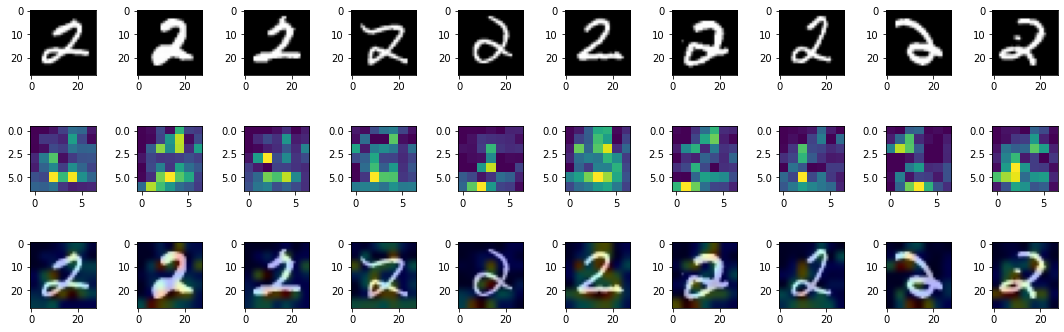

In [24]:
DIGIT = '2'
plot_ten_examples(DIGIT)

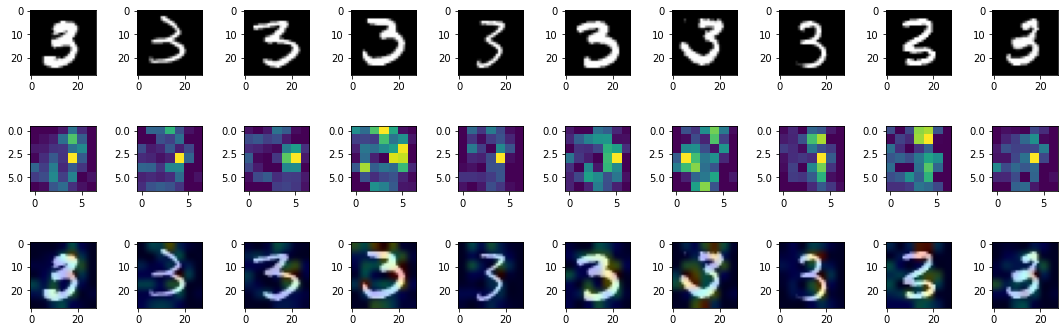

In [25]:
DIGIT = '3'
plot_ten_examples(DIGIT)

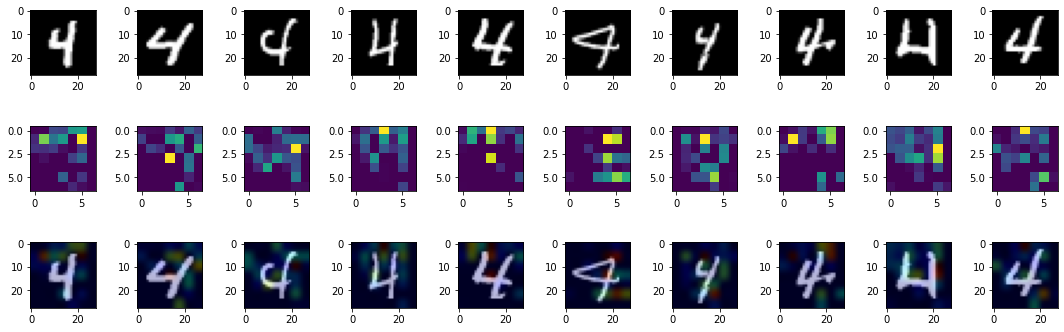

In [26]:
DIGIT = '4'
plot_ten_examples(DIGIT)

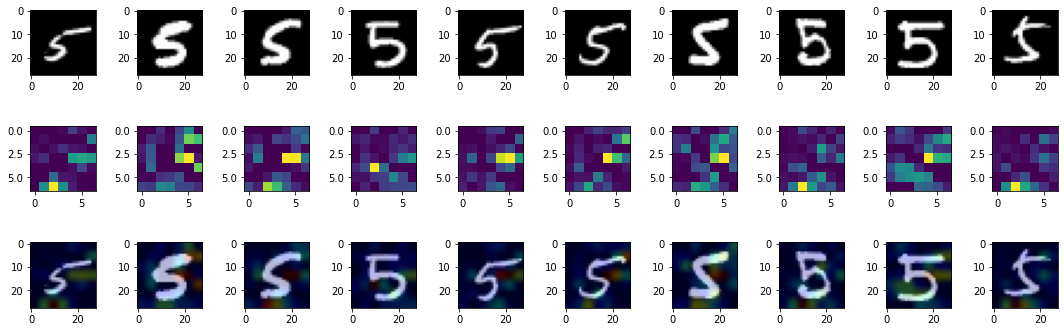

In [27]:
DIGIT = '5'
plot_ten_examples(DIGIT)

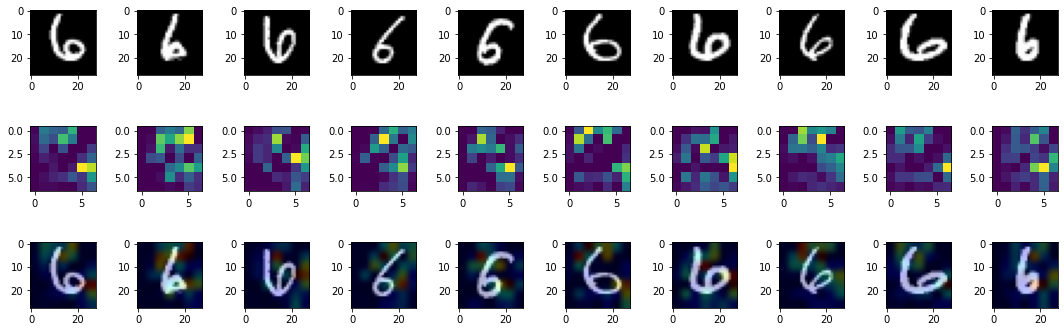

In [28]:
DIGIT = '6'
plot_ten_examples(DIGIT)

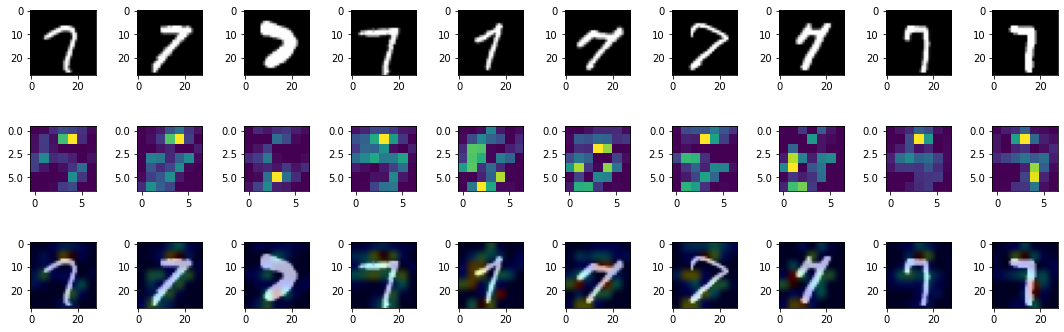

In [29]:
DIGIT = '7'
plot_ten_examples(DIGIT)

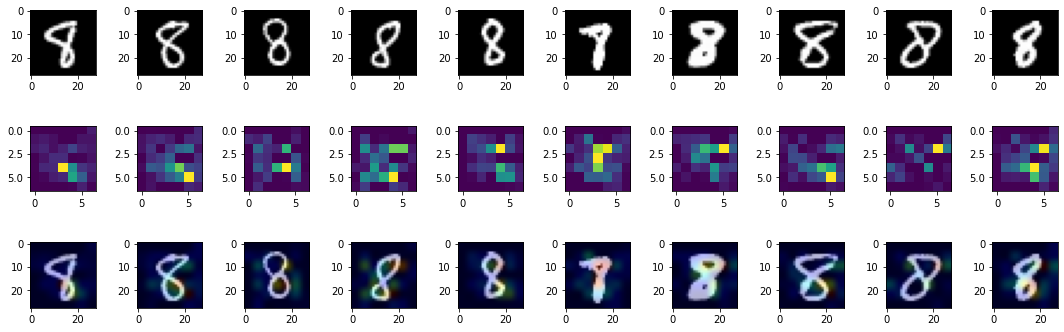

In [30]:
DIGIT = '8'
plot_ten_examples(DIGIT)

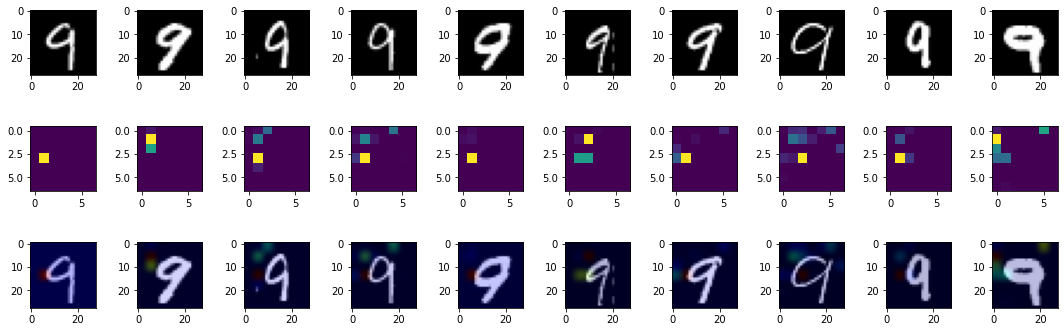

In [31]:
DIGIT = '9'
plot_ten_examples(DIGIT)